In [1]:
# !pip install gensim -q

In [1]:
import string

import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import gensim
from IPython.display import clear_output

import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
MODE = "local" # valid modes are 'local', 'colab' and 'kaggle'
SAMPLE_NUMBERS = 4

In [5]:
if   MODE == "local":
    BASE_PATH = "."
elif MODE == "colab":
    BASE_PATH = "/content/drive/MyDrive/Deep Neural Network - UT/CA 04/suicide_detection.ipynb"
else:
    print(f"Unknown mode {MODE}")
    exit(1)

In [6]:
DATA_PATH = os.path.join(BASE_PATH, "twitter-suicidal_data.csv")

W2V_PATH = os.path.join(BASE_PATH, "w2v_vectors.kv")


# Data Exploration

## Load Data

In [7]:
df = pd.read_csv(DATA_PATH)

## Data statistics

In [7]:
df.head(5)

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [9]:
print(f"Number of samples: {len(df)}")

Number of samples: 9119


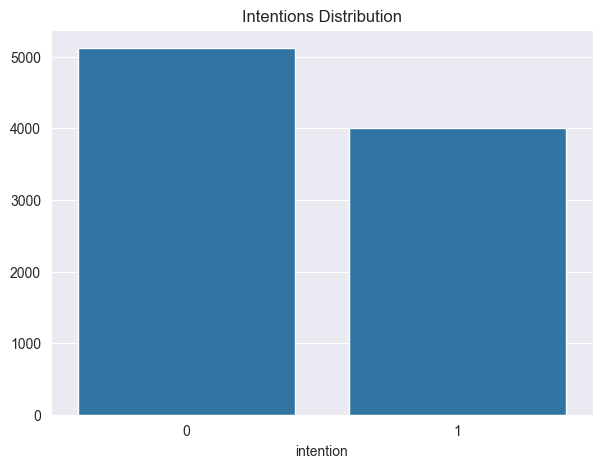

In [10]:
intentions = df["intention"].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(x=intentions.index, y=intentions.values)
plt.title("Intentions Distribution")
plt.show()

# Data Preprocessing

In [11]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pooyasadeghi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pooyasadeghi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pooyasadeghi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
def convert_emoji_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:          
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    0. concatenation of the text (not necessary)
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """
    # text = ''.join(text)
    # lowercase the text
    text = text.lower()
    # remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # remove numbers
    text = re.sub(r"\d+", "", text)
    # remove urls,
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # remove usernames
    text = re.sub(r'@\S+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # convert emojis to text
    text = convert_emoji_to_text(text)
    # remove non-word characters
    text = re.sub(r"[^\w\s]", "", text)
    # lemmatization and tokenization of the text
    tokenized = nltk.word_tokenize(text)
    pos_tag = nltk.pos_tag(tokenized)
    tokens = [
        lemmatizer.lemmatize(token, nltk_pos_tagger(tag))
        for token, tag in pos_tag
    ]
    # remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    
    return tokens
    

In [13]:
def format_length_bound(text: str, length:int):
    if len(text) <= length:
        return text
    mm = length // 2 - 3
    rr = length - mm - 5
    return text[:mm] + "|...|" + text[-rr:]
    
def draw_sample_processing(dataframe: pd.DataFrame, sample_numbers: int = SAMPLE_NUMBERS, show=True):
    sample_text = dataframe.sample(sample_numbers)
    label_rawT_procT = [
        (label, tweet, preprocess_data(tweet)) 
        for tweet, label in zip(sample_text["tweet"], sample_text["intention"])
    ]
    if show:
        for idx, (label, rawT, procT) in enumerate(label_rawT_procT, start=1):
            procT = str(procT)
            print(f"Sample {idx}:")
            print(f":::::::Label          : {label}")
            print(f":::::::Raw Tweet      : {format_length_bound(rawT, 50):<50} ({len(rawT)})")
            print(f":::::::Processed Tweet: {format_length_bound(procT, 50):<50} ({len(procT)})")
        return 
    return pd.DataFrame(label_rawT_procT, columns=["Intention", "Raw Tweet", "Processed Tweet"])

In [14]:
draw_sample_processing(df, show=True)

Sample 1:
:::::::Label          : 0
:::::::Raw Tweet      : i m tryna get on twitt|...| t let me use the comp  (83)
:::::::Processed Tweet: ['tryna', 'get', 'twit|...|, 'let', 'use', 'comp'] (90)
Sample 2:
:::::::Label          : 0
:::::::Raw Tweet      :  i m looking for it my|...|forecast for later too  (67)
:::::::Processed Tweet: ['look', 'rain', 'forecast', 'later']              (37)
Sample 3:
:::::::Label          : 0
:::::::Raw Tweet      : i want to die                                      (13)
:::::::Processed Tweet: ['want', 'die']                                    (15)
Sample 4:
:::::::Label          : 0
:::::::Raw Tweet      : in pain right now expecting more pain in due time  (50)
:::::::Processed Tweet: ['pain', 'right', 'expect', 'pain', 'due', 'time'] (50)


# Word2Vec - Word Embedding

In [15]:
# print available word2vec models
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [16]:
if os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Saving Word2Vec model...")
    w2v_model.save(W2V_PATH)
    

KeyboardInterrupt: 

In [ ]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

# DataSet

In [ ]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.dataframe["tokens"] = self.dataframe["tweet"].apply(preprocess_data)
        self.dataframe["tokens"] = self.dataframe["tokens"].apply(self._to_tensor)
        self.dataframe["tokens"] = self.dataframe["tokens"].apply(self._get_word_vectors)
        
        self.len = len(self.dataframe)
        self.vector_size = w2v_model.vector_size
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["tokens"], self.dataframe.iloc[idx]["intention"]
    
    def _get_word_vectors(self, tokens: list):
        # return [self.w2v_model[token] for token in tokens if token in self.w2v_model]
        wv = torch.zeros(self.vector_size)
        count = 0
        for token in tokens:
            if token in self.w2v_model:
                wv += torch.tensor(self.w2v_model[token])
                count += 1
        return wv / max(1, count)
    
    # def _pad(self, tokens: list):
    #     if len(tokens) >= self.max_length:
    #         return tokens[:self.max_length]
    #     return tokens + [np.zeros(EMBEDDING_VECTOR_DIM)] * (self.max_length - len(tokens))
    
    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

In [12]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["intention"])

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

## Create DataSet

In [13]:
train_dataset = Twitter(train_df, w2v_model)
valid_dataset = Twitter(valid_df, w2v_model)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

NameError: name 'Twitter' is not defined

# Model

## LSTM

In [ ]:
class DetectorLSTM(nn.Module):

## 2-Layer LSTM

## CNN+2-Layer-LSTM